## LPs and Max Flow/Min Cut

### If you're using Datahub:
* Run the cell below **and restart the kernel if needed**

### If you're running locally:
You'll need to perform some extra setup.
#### First-time setup
* Install Anaconda following the instructions here: https://www.anaconda.com/products/distribution 
* Create a conda environment: `conda create -n cs170 python=3.10`
* Activate the environment: `conda activate cs170`
    * See for more details on creating conda environments https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
* Install pip: `conda install pip`
* Install jupyter: `conda install jupyter`

#### Every time you want to work
* Make sure you've activated the conda environment: `conda activate cs170`
* Launch jupyter: `jupyter notebook` or `jupyter lab` 
* Run the cell below **and restart the kernel if needed**

In [87]:
# Install dependencies
# NOTE: if you have certain TSP solvers installed (for whatever reason), you may need to uninstall them
# as they don't play nicely with new versions of networkx. If you are using Datahub, this is not an
# issue for you (last tested: 10/27)
!pip install -r requirements.txt --quiet

In [88]:
import otter
assert (
    otter.__version__ >= "5.5.0"
), "Please reinstall the requirements and restart your kernel."

import numpy as np
import networkx as nx
import pulp
import tqdm
import pickle
from collections import deque
from unittest import mock

grader = otter.Notebook("hw09.ipynb")
rng_seed = 0

## Primer: Solving LPs with Python (Optional)
<b> For this part, you don't have to submit anything, but you can use it to solve the LPs in Q5 of the written portion. </b>

Here, we'll inroduce PuLP, which is a Python wrapper for various LP and integer LP solvers. In general, we'll treat the solver like a black box -- besides the Simplex algorithm we saw in class, you don't need to know any other LP solver algorithms or understand how PuLP works internally. In this question, we'll walk through the basics of formulating and solving LPs with PuLP.

As an example, let's say we want to solve the following LP:
$$\min_x \quad 3 x_0 + 4 x_1 + 6 x_2$$
<center> such that </center>

$$x_0 + 2 x_1 \ge 5$$
$$|x_1 - x_2| \le 2$$
$$x_0 + 2x_1 + 3x_2 \le 7$$
$$x_0, x_1, x_2 \ge 0$$

First, we initialize a `pulp.LpProblem`. The constructor takes 2 arguments: 
1. The name of the problem (can be anything)
2. An optimization direction (either `pulp.LpMinimize` or `pulp.LpMaximize`). 

In [89]:
problem = pulp.LpProblem('example_1', pulp.LpMaximize)

We can also change the optimization direction later using the `problem.sense` attribute.

In [90]:
problem.sense = pulp.LpMinimize

Next, we define our *optimization variables*. The variable constructor takes in a name parameter, followed by a few keyword arguments. For our purposes, we'll just look at the keyword arguments `lowBound`. `lowBound` is optional - we can have variables with no lower bound by omitting the argument or setting `lowBound=None`.

Not only does PuLP support defining single variables, but PuLP also supports defining multiple variables at once with the `dicts` method. This takes in an additional parameter `indices`, and returns a dictionary with elements of `indices` as keys and the PuLP variables as the values. `indices` could be any iterable, but here we'll use `range(3)` to make indexing easy. 

We'll also define an additional slack variable to deal with the absolute value constraint in our problem.

In [91]:
# Optimization variables
x = pulp.LpVariable.dicts(name='x', indices=range(3), lowBound=0)
# Slack variable
t = pulp.LpVariable(name='t', lowBound=0)

After defining our variables, we must set the *objective function*. This should be an affine function, i.e. involving only a linear combination of the optimization variables plus some constant. To make indexing easier, we can also define a coefficient array and use a list comprehension (or generator expression). 

Recall that `x` was assigned using the `dicts` constructor, which returns a dictionary where each key-value pair is of the form `(variable_name, variable_object)`. When defining the objective function, we want to work with the variables themselves but don't care about the names, so we'll iterate over just the values of the dictionary.

In [92]:
coeffs = [3, 4, 6]

# objectives can be hard-coded or set using a list comprehension
problem.setObjective(sum([c_i * x_i for c_i, x_i in zip(coeffs, x.values())]))

# this statement is equally valid and functionally equivalent - the square brackets are optional in a sum expression
problem.setObjective(sum(c_i * x_i for c_i, x_i in zip(coeffs, x.values())))

Finally, we'll define our *constraints*. PuLP does not require our LPs to be expressed in canonical form, so we can directly write `<=`, `>=`, and `==` constraints. Notice how we handled the absolute value constraint by using a slack variable. Also note that the nonnegativity constraints were taken care of using `lowBound` when we defined our variables, so we don't need to repeat them here.

In [93]:
problem.addConstraint(x[0] + 2*x[1] >= 5)

# handle the absolute value constraint using slack variables
problem.addConstraint(t >= x[1] - x[2])
problem.addConstraint(t >= -1*(x[1] - x[2]))
problem.addConstraint(t <= 2)

Just like when we set the objective function, if we are given a list of coefficients, we can quickly generate constraints using Python list comprehensions. Here, we use the `zip` function to iterate over the coefficients and the variables simultaneously.

If you want a refresher on `zip` or list comprehensions, consider checking out the following:

https://cs61a.org/study-guide/iterators/#generators 

https://cs61a.org/lab/lab04/#list-comprehensions

In [94]:
a = [1, 2, 3]

# just like before, the following two lines are equivalent and are both valid. 
problem.addConstraint(sum([a_i * x_i for a_i, x_i in zip(a, x.values())]) <= 7)

# the square brackets are optional here
problem.addConstraint(sum(a_i * x_i for a_i, x_i in zip(a, x.values())) <= 7)

We can print the problem to make sure our objective and constraints make sense:

In [95]:
print(problem)

example_1:
MINIMIZE
3*x_0 + 4*x_1 + 6*x_2 + 0
SUBJECT TO
_C1: x_0 + 2 x_1 >= 5

_C2: t - x_1 + x_2 >= 0

_C3: t + x_1 - x_2 >= 0

_C4: t <= 2

_C5: x_0 + 2 x_1 + 3 x_2 <= 7

_C6: x_0 + 2 x_1 + 3 x_2 <= 7

VARIABLES
t Continuous
x_0 Continuous
x_1 Continuous
x_2 Continuous



To actually solve or LP, we just call `problem.solve()`. 

Here, we pass `pulp.PULP_CBC_CMD(msg=0)` into `problem.solve()` to suppress console outputs and avoid cluttering the notebook. This is totally optional and can be removed if you like.

After optimizing, we should first check whether the solver found an optimal solution by checking `problem.status`. If `problem.status` is 1, then the solver found an optimal solution. Otherwise, the status will be different if the problem is infeasible, unbounded or if the solver otherwise fails. See the [documentation](https://www.coin-or.org/PuLP/constants.html#pulp.constants.LpStatus) for the full list of status values. 

If an optimal solution is found, we can get the optimum objective value from `problem.objective.value()` as shown below. The optimum variable values are stored in their respective variable objects.

> **Note:** If the solver fails to find an optimal solution (for instance if the problem is infeasible), the solver will not throw an error. Instead, the solver will set `problem.status` to something other than 1 and the objective value and objective variables will be garbage. So make sure to check that `problem.status` is 1 before checking the objective value or accessing the decision variables.

In [96]:
problem.solve(pulp.PULP_CBC_CMD(msg=0))
if problem.status == 1:
    print(f'Optimal objective value: {problem.objective.value()}')
else:
    print("The solver couldn't find an optimal solution.")

Optimal objective value: 11.0


> **Exercise (optional)**: Try adding a new constraint which will make the LP infeasible, and see what happens when you try to solve it by rerunning the cell above.

In [97]:
# add additional constraints here
a = [0, 0 ,0]
problem.addConstraint(sum([a_i * x_i for a_i, x_i in zip(a, x.values())]) >= 1)
problem.solve(pulp.PULP_CBC_CMD(msg=0))

-1

After solving, the we can use this code to extract the optimum variable values. `problem.variablesDict()` returns a dictionary of all variables which are used in our LP, and for each variable `v`, we can access `v.name` to see the variable's name or call `v.value()` to see its value.

In [98]:
[(v.name, v.value()) for v in problem.variablesDict().values()]

[('x_0', 0.0), ('x_1', 2.5), ('x_2', 0.0), ('t', 2.5)]

we can also use `problem.variables()` to get a list of all variables, and iterate over them to get their names and values.
> **Note:** Beware that this may not return variables in the order that you expect! (try changing $x$ to have dimension larger than 10 and see what happens)

In [99]:
[(v.name, v.value()) for v in problem.variables()]

[('t', 2.5), ('x_0', 0.0), ('x_1', 2.5), ('x_2', 0.0)]

If you have any further questions about PuLP or if you want to see more examples, feel free to consult the [documentation](https://coin-or.github.io/pulp/).

We can now use these tools to solve the LPs you wrote in Q5 of the written portion. This part will not be graded, so be sure to attach whatever you write here to your written submission!

_Points:_ 0

In [100]:
prob_q5c = pulp.LpProblem('q5c')


In [101]:
prob_q5d = pulp.LpProblem('q5d')


## Max Flow/Min Cut

Here, we will implement one well-defined implementation of Ford–Fulkerson algorithm: Edmonds–Karp algorithm.

What Ford–Fulkerson does can be summarised as 3 steps:

* Find an augmenting path in the graph
* Construct the residual graph by augmenting the path based on the original graph and augmenting path.
* Do this until no augmenting path can be found.

Ford-Fulkerson is not always well-defined because there could be multiple ways of doing step 0: by DFS, by A* search, by some RL model that takes 200 RTX A6000 to train, or by magic......


If we use BFS to find the augmenting path, this algorithm is called Edmonds–Karp algorithm which is what we will implement today.

> Fun fact: Edmonds–Karp algorithm was first introduced by Soviet mathematician Yefim Dinitz/Dinic, yet Dinic's Algorithm is the name of a more efficient but more complicated algorithm for Network Flow problems (out of scope for CS170).

In [102]:
prng1 = np.random.default_rng(seed=rng_seed)

# Load test cases
file_path = "generated_testcases.pkl"

# Load the variables from the pickle file
with open(file_path, "rb") as file:
    loaded_data = pickle.load(file)
inputs, outputs = loaded_data

In [103]:
def rand_graph(size=None):
    """
    args:
        size:int = number of vertices in randomly generated graph.
    return:
        nx.DiGraph that represents the randomly generated directed graph.
    """
    if not size:
        g = nx.gnp_random_graph(prng1.integers(16, 64), 0.25, seed=rng_seed, directed=True)
    else:
        g = nx.gnp_random_graph(size, 0.25, seed=rng_seed, directed=True)
        
    for u, v in g.edges:
        g.edges[u, v]["capacity"] = int(prng1.integers(0, 50))
    return g

Since we're dealing with networkx graphs, you can use `networkx` functions to visualize the graphs:

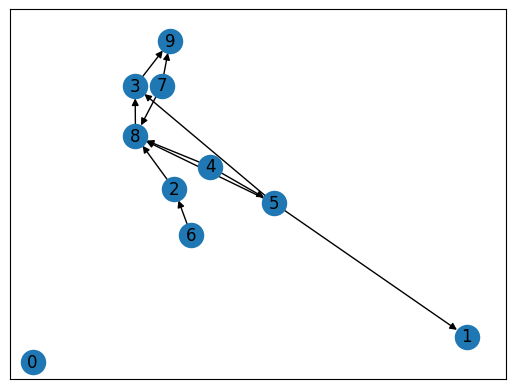

In [104]:
nx.draw_networkx(rand_graph(10), with_labels=True)

### Augmenting Path
First, you will implement the BFS portion of Edmonds–Karp algorithm.
Given a graph and `s` and `t` vertices, find a augmenting path (a list of vertices from `s` to `t` **including** `s` and `t`) with BFS. If there's no augmenting `s-t` path, return `[]`.

### Networkx tricks

There are some `networkx` tricks you might want to use below to make your life way easier:

To access the capacity from edge `(u, v)`, do `g.edges[u, v]["capacity"]`; by default, `capacity` is the only property of each edge, but if you choose to add more properties later on, you can access them in a similar way. Every edge has a capacity and (for this part), capacities are non-negative integers (but may be zero).

To access outgoing edges from `c` like adjacency list, do `g.edges(c)`. Note the returned type is an iterable of vertex tuples, so you should do something like:

```
for u, v in g.edges(c):
    e = g.edges[u, v]
    print(e["capacity"])
```
    
We can also add additional properties to the edges. 

For example, if we want to denote that an edge has flow $f$ going through it, we could run `g.edges[u, v]["flow"] = f`. This method can also be used to update the flow of an edge which already has some flow going through it. 

(you could also do something like `g.add_edge(u, v, capacity=c, flow=f)` where `c` is the capacity of the edge and `f` is the flow going through the edge, but if you do this, you need to be careful to specify all existing properties of the edge; otherwise, this information will be lost). 

If you are not sure whether an edge exists, you can use `g.has_edge(u, v)` to check, and if you are not sure whether an edge has property `property`, you can use `property in g.edges[u, v]`.

Although `g.edges[u, v]` looks like adjacency matrix, it is not; writing `g.edges[u][v]` is an error, and if `(u, v)` doesn't exist there would be `KeyError`.

### Q1) Find Augmenting Path

**Task**
* Given a graph represented via a networkx graph, use BFS to find the shortest augmenting path.
* Return a list of nodes where the $i$-th element in this list is the $i$-th node on the $s$-$t$ path. The first and last nodes should be $s$ and $t$ respectively. The path you return should be the shortest augmenting path from $s$ to $t$.
* If there are multiple shortest augmenting paths, return any of them.
* If no such path is available, return an empty list.

If you need a FIFO queue, we recommend Python's built-in `deque`. You can read more about `deque` [here](https://docs.python.org/3/library/collections.html#collections.deque).

**Autograding note:** The test cases in this part assumes that an edge can be included if the `capacity` of the edge is greater than 0. 
Depending on how you choose to represent flows in your graph, you may choose to modify this behavior later on. 

If you modify `bfs_augmenting_path` in a way that breaks the autograder for Q1, you can set `modified_augmenting_path` to `True` and the autograder 
will skip the Q1 test cases and replace your Q1 score with your score for Q2. 

In [105]:
# If you modify bfs_augmenting_path in a way that breaks
# the autograder and you want to replace your Q1 score
# with your Q2 score, set this to True. 
# Otherwise, leave it as False.
modified_augmenting_path = False

In [116]:
from collections import deque

def bfs_augmenting_path(g, s, t):
    """
    args:
        g: nx.DiGraph = directed network flow graph
        s: int = source node s
        t: int = sink node t
    return:
        List[int] representing the augmenting path that BFS finds. First 
            and last nodes should be s and t respectively. Return [] if 
            path doesn't exist. Ex: [s, a, b, t] if (s, a), (a, b), (b, t)
            is the shortest length augmenting path.
    """
    dq = deque([s])
    vis = set([s])
    parent = {s: None}  # Track the parent of each node to reconstruct the path

    while dq:
        u = dq.popleft()
        if u == t:
            path = []
            while u is not None:
                path.append(u)
                u = parent[u]
            return path[::-1]  # Reverse to get path from s to t

        for v in g.neighbors(u):
            if v not in vis and g[u][v]["capacity"] > g[u][v].get("flow", 0):
                dq.append(v)
                vis.add(v)
                parent[v] = u  # Record the parent to backtrack later

    return []  # No path found

## Debugging
A simplified set of test cases is provided below. You can use these to test your implementation. Feel free to add your own test cases to further test your code.

**Warning: Make sure you are not overwriting the provided test cases! If you want to modify the provided graphs, ensure you copy them first by calling `g.copy()`.**
The provided test cases provide your function with copies of the graphs, so you can modify them without affecting the original graph.

_Points:_ 3

In [117]:
for i in tqdm.tqdm(range(0, len(inputs['q1'])), desc ="Testing handmade graphs:"):
    g, s, t = inputs['q1'][i]
    path_student = bfs_augmenting_path(g.copy(), s, t) 

    admissable_subgraph = nx.subgraph_view(g, filter_edge=lambda u, v: g.edges[u, v]["capacity"] > 0)
    
    if not nx.has_path(admissable_subgraph, s, t):
        assert len(path_student) == 0, f"you returned an augmenting s-t path when there isn't one."
    else:
        # checks that the path returned is a valid simple path in the graph
        # checks that the path starts at s and ends at t
        # checks that the path is the shortest path from s to t
        assert nx.is_simple_path(admissable_subgraph, path_student), f"you did not return a valid simple augmenting path"
        assert path_student[0] == s, f"your path does not start at s"
        assert path_student[-1] == t, f"your path does not end at t"
        shortest_path_len = nx.shortest_path_length(admissable_subgraph, s, t, weight=None)
        assert len(path_student) == shortest_path_len + 1, f"your path is not a shortest path from s to t"
print("Test cases passed!")

Testing handmade graphs:: 100%|██████████| 31/31 [00:00<00:00, 4912.11it/s]

Test cases passed!


In [118]:
grader.check("q1")

Testing random graphs:: 100%|██████████| 100/100 [00:01<00:00, 63.46it/s]


q1 results: All test cases passed!

### Q2) Edmonds-Karp

Now, implement Edmonds-Karp with the functions you made above:

1. Find an augmenting path in the graph (with `bfs_augmenting_path`)
2. Construct the residual graph by augmenting the path based on the original graph and augmenting path.
3. Do this until no augmenting path can be found.

If you want to, you may modify your `bfs_augmenting_path` however you need. 

Return the capacity and the final residual graph. You may modify the graph however you like to track flow and residual capacity, but make sure that:
1. In the output graph, every edge that you push flow through has a `flow` property which is equal to the flow pushed through that edge. If you add additional edges to the graph, ensure that they either lack a `flow` property or have a `flow` property of 0 (e.g. if you add reverse edges to the graph, ensure you do not try to push flow through them in your final solution).
2. **If you write your own test cases, do not overwrite the provided graphs**.

> *Hint:* You may find it helpful to fill in the helper function `augment` which takes in a grap and a path and augments the flow along that path by as much as possible.

In [132]:
def edmonds_karp(g, s, t):
    """
    args:
        g:nx.DiGraph = directed network flow graph
        s:int = source node s
        t:int = sink node t
    return:
        Tuple(int, nx.DiGraph) where the first value represents the max flow that
            was successfully pushed, and the second value represents the graph
            where the flow values along each edge represents the flow pushed through
            that edge.
    """    
    # TODO: Implement the augment helper function (optional).
    # You may modify the function signature or delete the function entirely if you want. 
    def augment(g, path):
        # Find the minimum residual capacity along the path
        flow = float('inf')
        for u, v in zip(path, path[1:]):
            flow = min(flow, g[u][v]["capacity"] - g[u][v].get("flow", 0))

        # Push the flow along the path
        for u, v in zip(path, path[1:]):
            if "flow" not in g[u][v]:
                g[u][v]["flow"] = 0
            g[u][v]["flow"] += flow
            if not g.has_edge(v, u):
                g.add_edge(v, u, capacity=0, flow=0)
            g[v][u]["flow"] -= flow
        return flow


    max_flow = 0

    for u, v in g.edges:
        if "flow" not in g[u][v]:
            g[u][v]["flow"] = 0

    new_g = g.copy()

    while True:
        # Find an augmenting path
        path = bfs_augmenting_path(g, s, t)
        if path == []:
            break

        max_flow += augment(g, path)

        for u, v in zip(path, path[1:]):
            if new_g.has_edge(u, v):
                new_g[u][v]["flow"] = g[u][v]["flow"]
            else:
                new_g[v][u]["flow"] = g[u][v]["flow"]

    return max_flow, new_g

In [133]:
grader.check("q2")

Testing random graphs:: 100%|██████████| 100/100 [00:02<00:00, 45.35it/s]


q2 results: All test cases passed!

## Debugging
A simplified set of test cases is provided below. You can use these to test your implementation. Feel free to add your own test cases to further test your code.

**Warning: Make sure you are not overwriting the provided test cases! If you want to modify the provided graphs, ensure you copy them first by calling `g.copy()`.**
The provided test cases provide your function with copies of the graphs, so you can modify them without affecting the original graph.

In [129]:
for i in tqdm.tqdm(range(0, len(inputs['q1'])), desc ="Testing handmade graphs:"):
    g, s, t = inputs['q2'][i]

    flow_student, g_student = edmonds_karp(g.copy(), s, t)

    for u, v in g_student.edges:
        assert g_student.has_edge(u, v), f"strange error, edge ({u}, {v}) does not exist in the graph"
        assert "flow" in g_student.edges[u, v], f"strange error, edge ({u}, {v}) does not have a flow attribute"
        assert g.has_edge(u, v) or g_student.edges[u, v].get("flow", 0) == 0, f"You are pushing flow through a non-existent edge, ({u}, {v})"
        assert g_student.edges[u, v]["flow"] <= g.edges[u, v]["capacity"], f"Your flow exceeds the capacity of an edge"

    for v in g_student.nodes:
        flow_in = sum(g_student.edges[u, v].get("flow", 0) for u, v in g_student.in_edges(v, data=False))
        flow_out = sum(g_student.edges[v, u].get("flow", 0) for v, u in g_student.out_edges(v, data=False))
        assert (flow_in == flow_out) or (v == s) or (v == t), f"Flow conservation is not satisfied at node {v}"

    start_flow = sum(g_student.edges[s, v].get("flow", 0) for _, v in g.out_edges(s, data=False))
    end_flow = sum(g_student.edges[u, t].get("flow", 0) for u, _ in g.in_edges(t, data=False))
    assert start_flow == end_flow == flow_student, f"Max flow value does not match flow values in the graph"

    max_flow_val = nx.maximum_flow_value(g, s, t)
    assert flow_student == max_flow_val, f"Your flow is not maximal"
print("Test cases passed!")

Testing handmade graphs:: 100%|██████████| 31/31 [00:00<00:00, 1000.06it/s]

Test cases passed!


### Q3) Min-Cut

Recall that the dual of the Max-Flow problem is the Min-Cut problem. In the Min-Cut problem, we are given a network, and we wish to find a vertex cut of this graph, $(S, T)$ where $S \cup T = V,$ $S \cap T = \emptyset,$ $s \in S, t \in T$ such that the sum of the capacities of the edges spanning this cut is minimized. 

Here, we'll see how, given a solution to the max-flow problem on a graph, we can easily find the min cut. Implement `find_min_cut` to find the minimum S-T cut of this graph (which also yields the edges with saturated flow). Make sure to return all the vertices that belong to the $S$ partition of the cut.

In [138]:
def find_min_cut(g, s, t):
    """
    args:
        g:nx.DiGraph = directed network flow graph
        s:int = source node s
        t:int = sink node t
    return:
        Set(int) that contains all vertices in the min cut of g that includes s.
    """
    vertex_cut_s = set([s])
    flow, graph = edmonds_karp(g, s, t)
    
    # Find all vertices reachable from s in the residual graph
    dq = deque([s])

    while dq:
        u = dq.popleft()
        for v in graph.neighbors(u):
            if v not in vertex_cut_s and graph[u][v]["capacity"] > graph[u][v]["flow"]:
                dq.append(v)
                vertex_cut_s.add(v)

    return vertex_cut_s

In [139]:
grader.check("q3")

Testing random graphs::  83%|████████▎ | 83/100 [00:01<00:00, 48.85it/s]


q3 results:
    q3 - 1 result:
        ❌ Test case failed
        Error at line 46 in test q3:
                  check_correctness(min_cut_student, g, s, t)
        AssertionError: Your cut is not the minimum cut

## Debugging
A simplified set of test cases is provided below. You can use these to test your implementation. Feel free to add your own test cases to further test your code.

**Warning: Make sure you are not overwriting the provided test cases! If you want to modify the provided graphs, ensure you copy them first by calling `g.copy()`.**
The provided test cases provide your function with copies of the graphs, so you can modify them without affecting the original graph.

In [136]:
def check_correctness(student_cut, g, s, t):
    assert min_cut_student.issubset(g.nodes), f"Your partition contains nodes that are not in the graph"
    assert s in min_cut_student, f"Your partition does not include the source node"
    assert t not in min_cut_student, f"Your partition includes both the source and sink nodes"

    # ensure optimality
    cut_size_student = 0
    for u, v in g.edges:
        if u in min_cut_student and v not in min_cut_student:
            cut_size_student += g.edges[u, v]["capacity"]

    min_cut_val = nx.minimum_cut_value(g, s, t)
    assert cut_size_student == min_cut_val, f"Your cut is not the minimum cut"

for i in tqdm.tqdm(range(0, len(inputs['q3'])), desc ="Testing handmade graphs:"):
    g, s, t = inputs['q3'][i]
    min_cut_student = set(find_min_cut(g.copy(), s, t)) 
    check_correctness(min_cut_student, g, s, t)

Testing handmade graphs:: 100%|██████████| 31/31 [00:00<00:00, 1722.64it/s]


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [140]:
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>